In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import spacy
import tensorflow as tf

from tensorflow import keras
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


In [2]:
embedding_dim = 200
maxlen = 64
clear_embedding_matrix = False

In [16]:
def recall_metric(y_true, y_pred):	
    """Recall metric.	
     Only computes a batch-wise average of recall.	
     Computes the recall, a metric for multi-label classification of	
    how many relevant items are selected.	
    """	
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))	
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))	
    recall = true_positives / (possible_positives + K.epsilon())	
    return recall

In [4]:
def save_model(model, model_path="data/models/MSA_cnn_model.json", weights_path="data/models/MSA_cnn_model.hdf"):
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_path, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(weights_path)
    print("Saved model to data/models/MSA_cnn_model.json")

In [5]:
with open("models/tokenizer.pickle", "rb") as handle:
    tokenizer = pickle.load(handle)
print("loaded tokenizer from models/tokenizer.pickle")
vocab_size = len(tokenizer.word_index) + 1

loaded tokenizer from models/tokenizer.pickle


In [6]:
if os.path.exists("models/embedding_matrix.pickle") and not clear_embedding_matrix:
    with open("models/embedding_matrix.pickle", "rb") as handle:
        embedding_matrix = pickle.load(handle)
    print("loaded embedding_matrix from models/embedding_matrix.pickle")
else:
    print("models/embedding_matrix.pickle not found; creating a new embedding_matrix")
    vocab_size = len(tokenizer.word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(glove_filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in tokenizer.word_index:
                idx = tokenizer.word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    # save for the future
    with open("models/embedding_matrix.pickle", "wb") as handle:
        pickle.dump(embedding_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("saving embedding_matrix to models/embedding_matrix.pickle")

loaded embedding_matrix from models/embedding_matrix.pickle


In [7]:
training_df = pd.read_csv('data/training_data/moral_training_set.csv')
training_df.head()

,text,moral_saliency,moral_intrinsicality,notes
0,All human beings have inherent worth.,1,3,NaN
1,It's wrong to exploit people you have power over.,1,2,NaN
2,Jeff Bezos is an evil man.,1,1,NaN
3,Human beings have a brain that resides in thei...,0,0,NaN
4,It's incorrect to assume that one plus one is ...,0,0,NaN


In [8]:
train = training_df.sample(frac=0.666)
test = training_df.drop(train.index)
print("train len: ", len(train))
print("test len: ", len(test))

train len:  100
test len:  50


In [9]:
input_train = tokenizer.texts_to_sequences(train["text"].values)
input_test = tokenizer.texts_to_sequences(test["text"].values)

In [10]:
input_train = pad_sequences(input_train, padding='post', maxlen=maxlen)
input_test = pad_sequences(input_test, padding='post', maxlen=maxlen)

In [11]:
output_train = train["moral_saliency"]
output_test = test["moral_saliency"]

In [20]:
def plot_training(history):
    acc = history.history["acc"]
    val_acc = history.history["val_acc"]
    plt.style.use("ggplot")
    plt.plot(acc, color=(0.1, 0.2, 0.6, 0.6), label="train acc", lw=3)
    plt.plot(val_acc, color=(0.1, 0.6, 0.2, 0.6), label="validation acc", lw=3)
    plt.suptitle("MSA Training Accuracy\n\n", fontsize=16, y=1.05)
    plt.legend()
    plt.show()
    recall = history.history["recall_metric"]
    val_recall = history.history["val_recall_metric"]
    plt.style.use("ggplot")
    plt.plot(recall, color=(0.1, 0.2, 0.6, 0.6), label="train recall", lw=3)
    plt.plot(val_recall, color=(0.1, 0.6, 0.2, 0.6), label="validation recall", lw=3)
    plt.suptitle("MSA Training Recall\n\n", fontsize=16, y=1.05)
    plt.legend()
    plt.show()

# A Very Simple Model

In [28]:
# Create a new model
very_simple_model = keras.Sequential()
very_simple_model.add(keras.layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
very_simple_model.add(keras.layers.GlobalMaxPool1D())
very_simple_model.add(keras.layers.Dropout(0.2))
very_simple_model.add(keras.layers.Dense(1, activation='sigmoid'))
very_simple_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=["accuracy", recall_metric])
very_simple_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 64, 200)           61876400  
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 200)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 201       
Total params: 61,876,601
Trainable params: 201
Non-trainable params: 61,876,400
_________________________________________________________________


Testing Accuracy:  0.5200
Testing Recall:  0.5547


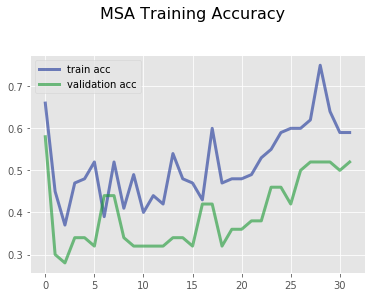

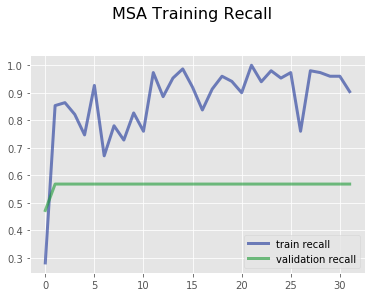

In [29]:
history = very_simple_model.fit(input_train, output_train,
                    epochs=32,
                    verbose=0,
                    validation_data=(input_test, output_test),
                    batch_size=8,
                    class_weight={1: 10, 0: 1})
loss, accuracy, recall = very_simple_model.evaluate(input_test, output_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Recall:  {:.4f}".format(recall))
plot_training(history)

# A Model With 1 Dense Hidden Layer

In [30]:
# Create a new model
one_dense_layer_model = keras.Sequential()
one_dense_layer_model.add(keras.layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
one_dense_layer_model.add(keras.layers.GlobalMaxPool1D())
one_dense_layer_model.add(keras.layers.Dense(32, activation='relu'))
one_dense_layer_model.add(keras.layers.Dropout(0.5))
one_dense_layer_model.add(keras.layers.Dense(1, activation='sigmoid'))
one_dense_layer_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=["accuracy", recall_metric])
one_dense_layer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 64, 200)           61876400  
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                6432      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 61,882,865
Trainable params: 6,465
Non-trainable params: 61,876,400
_________________________________________________________________


Testing Accuracy:  0.4800
Testing Recall:  0.6400


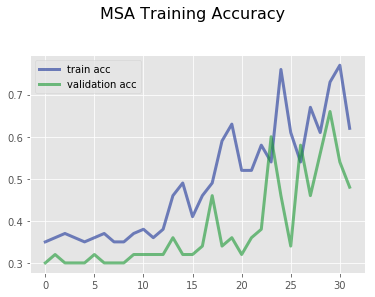

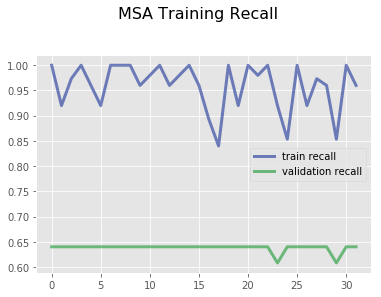

In [31]:
history = one_dense_layer_model.fit(input_train, output_train,
                    epochs=32,
                    verbose=0,
                    validation_data=(input_test, output_test),
                    batch_size=8,
                    class_weight={1: 10, 0: 1})
loss, accuracy, recall = one_dense_layer_model.evaluate(input_test, output_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Recall:  {:.4f}".format(recall))
plot_training(history)

# A Model with 1 Convolutional Layer

In [37]:
# Create a new model
one_conv_layer_model = keras.Sequential()
one_conv_layer_model.add(keras.layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
one_conv_layer_model.add(keras.layers.Dropout(0.2))
one_conv_layer_model.add(keras.layers.Conv1D(filters=32, kernel_size=4))
one_conv_layer_model.add(keras.layers.Dropout(0.2))
one_conv_layer_model.add(keras.layers.GlobalMaxPool1D())
one_conv_layer_model.add(keras.layers.Dropout(0.2))
one_conv_layer_model.add(keras.layers.Dense(1, activation='sigmoid'))
one_conv_layer_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=["accuracy", recall_metric])
one_conv_layer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 64, 200)           61876400  
_________________________________________________________________
dropout_10 (Dropout)         (None, 64, 200)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 61, 32)            25632     
_________________________________________________________________
dropout_11 (Dropout)         (None, 61, 32)            0         
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 32)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total para

Testing Accuracy:  0.8400
Testing Recall:  0.6400


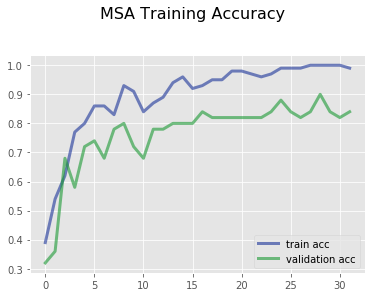

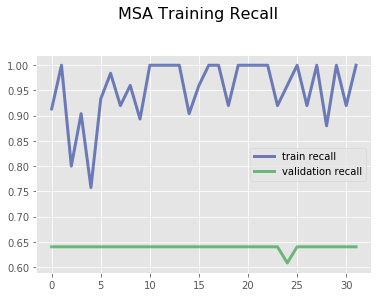

In [38]:
history = one_conv_layer_model.fit(input_train, output_train,
                    epochs=32,
                    verbose=0,
                    validation_data=(input_test, output_test),
                    batch_size=8,
                    class_weight={1: 10, 0: 1})
loss, accuracy, recall = one_conv_layer_model.evaluate(input_test, output_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Recall:  {:.4f}".format(recall))
plot_training(history)

# 1 Conv and 1 Dense Layer

In [44]:
# Create a new model
conv_dense_model = keras.Sequential()
conv_dense_model.add(keras.layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
conv_dense_model.add(keras.layers.Dropout(0.3))
conv_dense_model.add(keras.layers.Conv1D(filters=32, kernel_size=4))
conv_dense_model.add(keras.layers.Dropout(0.3))
conv_dense_model.add(keras.layers.GlobalMaxPool1D())
conv_dense_model.add(keras.layers.Dropout(0.3))
conv_dense_model.add(keras.layers.Dense(32, activation='relu'))
conv_dense_model.add(keras.layers.Dropout(0.3))
conv_dense_model.add(keras.layers.Dense(1, activation='sigmoid'))
conv_dense_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=["accuracy", recall_metric])
conv_dense_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 64, 200)           61876400  
_________________________________________________________________
dropout_25 (Dropout)         (None, 64, 200)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 61, 32)            25632     
_________________________________________________________________
dropout_26 (Dropout)         (None, 61, 32)            0         
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 32)                0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 32)                1056      
__________

Testing Accuracy:  0.8800
Testing Recall:  0.6400


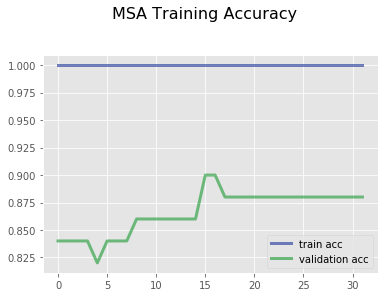

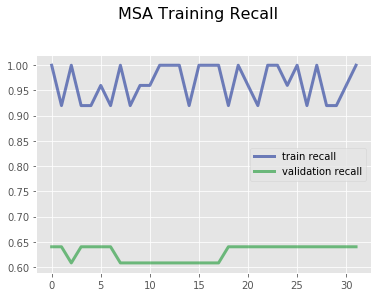

In [45]:
history = one_conv_layer_model.fit(input_train, output_train,
                    epochs=32,
                    verbose=0,
                    validation_data=(input_test, output_test),
                    batch_size=8,
                    class_weight={1: 16, 0: 1})
loss, accuracy, recall = one_conv_layer_model.evaluate(input_test, output_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Recall:  {:.4f}".format(recall))
plot_training(history)

In [12]:
# Create a new model
msa_cnn_model = keras.Sequential()
msa_cnn_model.add(keras.layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
msa_cnn_model.add(keras.layers.Conv1D(filters=32, kernel_size=4))
msa_cnn_model.add(keras.layers.GlobalMaxPool1D())
msa_cnn_model.add(keras.layers.Dense(32, activation='relu'))
msa_cnn_model.add(keras.layers.Dropout(0.5))
msa_cnn_model.add(keras.layers.Dense(1, activation='sigmoid'))
msa_cnn_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=["accuracy", recall])
msa_cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 64, 200)           61876400  
_________________________________________________________________
conv1d (Conv1D)              (None, 61, 32)            25632     
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 61,903,121
Trainable params: 26,721
Non-trainable params: 61,876,400
___________________________________________________________

In [13]:
history = msa_cnn_model.fit(input_train, output_train,
                    epochs=16,
                    verbose=1,
                    validation_data=(input_test, output_test),
                    batch_size=8,
                    class_weight={1: 4, 0: 1})
loss, accuracy, recall = msa_cnn_model.evaluate(input_test, output_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Recall:  {:.4f}".format(recall))

Train on 120 samples, validate on 30 samples
Epoch 1/16
120/120 [==============================] - 1s 10ms/step - loss: 0.7776 - acc: 0.4167 - recall: 0.5433 - val_loss: 0.8209 - val_acc: 0.3000 - val_recall: 0.8000
Epoch 2/16
120/120 [==============================] - 0s 756us/step - loss: 0.6052 - acc: 0.6083 - recall: 0.8311 - val_loss: 0.5889 - val_acc: 0.8000 - val_recall: 0.8000
Epoch 3/16
120/120 [==============================] - 0s 696us/step - loss: 0.4994 - acc: 0.7083 - recall: 0.7389 - val_loss: 0.5380 - val_acc: 0.8667 - val_recall: 0.8000
Epoch 4/16
120/120 [==============================] - 0s 635us/step - loss: 0.3876 - acc: 0.7917 - recall: 0.9111 - val_loss: 0.4686 - val_acc: 0.9000 - val_recall: 0.8000
Epoch 5/16
120/120 [==============================] - 0s 752us/step - loss: 0.3340 - acc: 0.8917 - recall: 0.8867 - val_loss: 0.3342 - val_acc: 0.9667 - val_recall: 0.8000
Epoch 6/16
120/120 [==============================] - 0s 657us/step - loss: 0.2497 - acc: 0.9833

In [17]:
save_model(msa_cnn_model, model_path="data/models/msa_model.json", weights_path="data/models/msa_weights.hdf")


Consider using a TensorFlow optimizer from `tf.train`.
Saved model to data/models/MSA_cnn_model.json


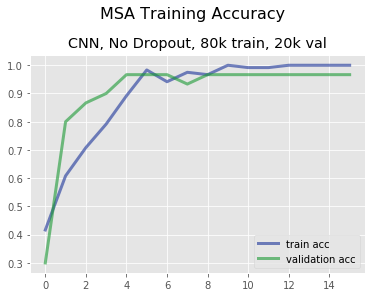

In [14]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]
plt.style.use("ggplot")
plt.plot(acc, color=(0.1, 0.2, 0.6, 0.6), label="train acc", lw=3)
plt.plot(val_acc, color=(0.1, 0.6, 0.2, 0.6), label="validation acc", lw=3)
plt.suptitle("MSA Training Accuracy\n\n", fontsize=16, y=1.05)
plt.title("CNN, No Dropout, 80k train, 20k val", y=1.01)
plt.legend()
plt.savefig("graphs/GSA-CNN-ND.png")
plt.show()

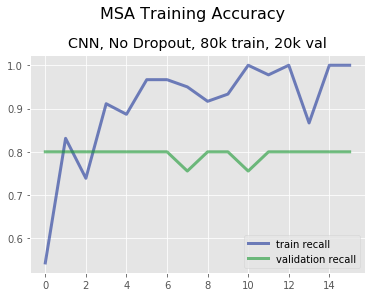

In [15]:
acc = history.history["recall"]
val_acc = history.history["val_recall"]
plt.style.use("ggplot")
plt.plot(acc, color=(0.1, 0.2, 0.6, 0.6), label="train recall", lw=3)
plt.plot(val_acc, color=(0.1, 0.6, 0.2, 0.6), label="validation recall", lw=3)
plt.suptitle("MSA Training Accuracy\n\n", fontsize=16, y=1.05)
plt.title("CNN, No Dropout, 80k train, 20k val", y=1.01)
plt.legend()
plt.savefig("graphs/GSA-CNN-ND.png")
plt.show()

In [51]:
test_set = pd.read_csv("data/training_data/moral_test_set.csv")
test_set.head()

,text,moral_saliency,moral_intrinsicality,notes
0,The most ethical course of action is the one t...,1,3,Consequentialism (utilitarianism); colloquial
1,Results of actions don't matter as much as the...,1,3,Deontology; colloquial
2,Morality is about becoming the right kind of p...,1,3,Virtue Ethics; colloquial
3,Act only according to that maxim whereby you c...,1,3,"Deontology; Immanuel Kant, Groundwork of Metap..."
4,The said truth is that it is the greatest happ...,1,3,Consequentialism (utilitarianism); Jeremy Bent...


In [53]:
count = 0
wrong = 0
count_pos = 0
wrong_pos = 0
for index, row in test_set.iterrows():
    count += 1
    text_sequence = tokenizer.texts_to_sequences([row["text"]])
    padded_text_sequence = pad_sequences(text_sequence, padding='post', maxlen=maxlen)
    result = msa_cnn_model.predict(padded_text_sequence)
    if row["moral_saliency"] == 1:
        count_pos += 1
    if np.round(result) != row["moral_saliency"]:
        wrong += 1
        if row["moral_saliency"] == 1:
            wrong_pos += 1
        print(row)
print("\n\n")
print("Accuracy: ", (count - wrong) / count)
print("Recall: ", (count_pos - wrong_pos) / count_pos)

text                    The most ethical course of action is the one t...
moral_saliency                                                          1
moral_intrinsicality                                                    3
notes                       Consequentialism (utilitarianism); colloquial
Name: 0, dtype: object
text                    Results of actions don't matter as much as the...
moral_saliency                                                          1
moral_intrinsicality                                                    3
notes                                              Deontology; colloquial
Name: 1, dtype: object
text                    Morality is about becoming the right kind of p...
moral_saliency                                                          1
moral_intrinsicality                                                    3
notes                                           Virtue Ethics; colloquial
Name: 2, dtype: object
text                    Act only according 

In [77]:
text = "profit is more important than equality"
text_sequence = tokenizer.texts_to_sequences([text])
padded_text_sequence = pad_sequences(text_sequence, padding='post', maxlen=maxlen)
result = model.predict(padded_text_sequence)
print(result)
if result[0][0] > 0.5:
    print("MORAL")
else:
    print("NOT MORAL")

[[0.57233083]]
MORAL


In [ ]:
save_model(model)